In [70]:
import os
import json
from time import time
from collections import Counter

%matplotlib inline
from IPython.core.display import HTML

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

# LDA
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

text_path = 'data/preprocessed_text.json'

In [2]:
with open('data/preprocessed_text.json', 'r') as f:
    data = json.load(f)
len(data.keys())

33375

### Exploratory analysis: Word Cloud
Visualize the most frequent words in all the abstracts of the papers in a single image. 
Analysis of what we see ??

In [24]:
all_abstracts_text = ' '.join([paper_json['abstract'] for paper_json in data.values()])
num_unique_words = len(set(all_abstracts_text.split(' ')))

print("Num unique words in abstracts: {}".format(num_unique_words))

Num unique words in abstracts: 149539


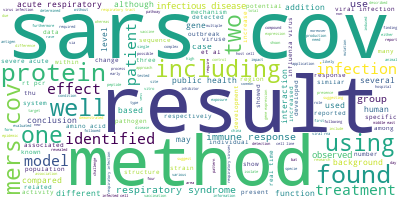

In [16]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(all_abstracts_text[:])

wordcloud.to_image()

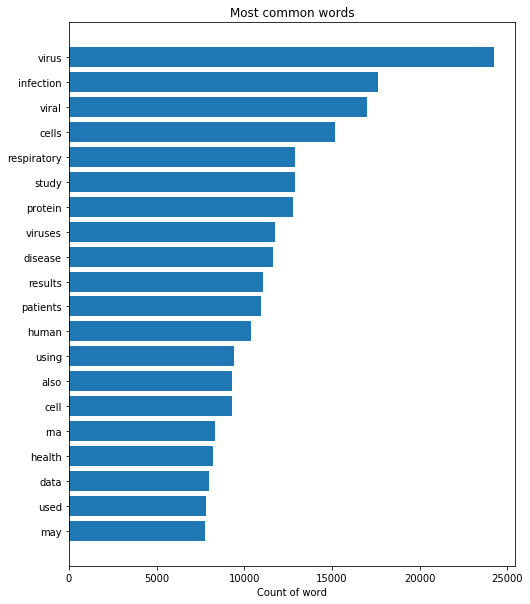

In [20]:
def plot_most_common_words(text, n_words=15, max_words=1000000):
    words = word_tokenize(text)
    word_cnt = Counter(words)
    word_cnt = {word: cnt for word, cnt in word_cnt.items() if cnt <= max_words}
    word_cnt = sorted(word_cnt.items(), key=lambda item: item[1], reverse=True)
    words, counts = zip(*word_cnt)
    
    #plt.figure(figsize=(8, 6))
    fig, ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(8)
    ax.barh(np.arange(n_words), counts[:n_words], align='center')
    ax.set_yticks(np.arange(n_words))
    ax.set_yticklabels(words[:n_words])
    ax.invert_yaxis()  # labels read top-to-bottom
    
    ax.set_xlabel('Count of word')
    ax.set_title('Most common words')
    
    #plt.bar(np.arange(n_words), counts[:n_words])
    #plt.xticks(np.arange(n_words), words[:n_words], rotation=45)
    plt.show()
    
    
plot_most_common_words(all_abstracts_text, n_words=20)

## Topic modelling: LDA
The following cells perform topic modelling on the **abstracts** of the papers with a varying pre-specified number of topics.

In [48]:
all_abstracts = [paper_json['abstract'] for paper_json in data.values()]
vectorizer = CountVectorizer(min_df=3, max_df=0.95)
count_data =  vectorizer.fit_transform(all_abstracts)
print("Data shape: ", count_data.shape)

Data shape:  (33375, 32561)


In [82]:
pyLDAvis.enable_notebook()

class LDA():
    def __init__(self, n_topics):
        self.n_topics = n_topics
        
        self.model = LatentDirichletAllocation(n_components=n_topics, n_jobs=-1, learning_method='online', 
                                               max_iter=10, batch_size=256, random_state=0, verbose=1)
        
    def store_model(self, count_data, vectorizer):
        model_dir = os.path.join('data', 'lda_{}_topics'.format(self.n_topics))
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        
        filename_to_object = {
            'model.pkl': self.model,
            'count_data.pkl': count_data,
            'vectorizer.pkl': vectorizer
        }
        
        for filename, obj in filename_to_object.items():
            full_path = os.path.join(model_dir, filename)
            
            with open(full_path, 'wb') as f:
                pickle.dump(obj, f)
                
            print("Pickling in {}".format(full_path))
            
    def load_model(self):
        model_path = os.path.join('data', 'lda_{}_topics'.format(self.n_topics), 'model.pkl')
        
        with open(model_path, 'rb') as f:
            self.model = pickle.load(f)
            
        print("Model loaded from: {}".format(model_path))
        
    def fit(self, count_data):
        start_time = time()
        self.model.fit(count_data)
        elapsed_time = (time() - start_time) / 60 # in minutes
        print("LDA fit in {} mins.".format(int(elapsed_time)))
        
    def print_topics(self, vectorizer, n_top_words):
        words = vectorizer.get_feature_names()
        for topic_idx, topic in enumerate(self.model.components_):
            print("\nTopic #%d:" % topic_idx)
            print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
            
    def interactive_visualization(self, count_data, vectorizer):
        LDAvis_data_filepath = os.path.join('.' , 'data', 'ldavis_{}'.format(n_topics)) 

        self.LDAvis_prepared = sklearn_lda.prepare(self.model, count_data, vectorizer)
        with open(LDAvis_data_filepath, 'wb') as f:
                pickle.dump(self.LDAvis_prepared, f)

        LDAvis_html_path = os.path.join('data', 'ldavis_{}.html'.format(n_topics))            
        pyLDAvis.save_html(self.LDAvis_prepared, LDAvis_html_path)

        #pyLDAvis.enable_notebook()
        # pyLDAvis.display(self.LDAvis_prepared)

### LDA experiment: 10 topics

In [83]:
n_topics = 10
lda = LDA(n_topics)
lda.fit(count_data)
lda.store_model(count_data, vectorizer)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
LDA fit in 7 mins.
Pickling in data\lda_10_topics\model.pkl
Pickling in data\lda_10_topics\count_data.pkl
Pickling in data\lda_10_topics\vectorizer.pkl


In [84]:
lda.print_topics(vectorizer, 10)


Topic #0:
review new based viral viruses development used diseases human studies

Topic #1:
pcr respiratory samples virus detection viruses positive assay viral detected

Topic #2:
patients respiratory clinical infection associated acute study disease pneumonia age

Topic #3:
analysis genes gene sequences sequence two results different genetic genome

Topic #4:
cells infection cell expression immune virus viral ifn response mice

Topic #5:
cov sars mers vaccine protein antibodies coronavirus antibody human vaccines

Topic #6:
protein rna proteins viral virus replication membrane activity binding cells

Topic #7:
virus viruses infection strains disease pedv strain viral ibv porcine

Topic #8:
health disease public data transmission control outbreak model infectious risk

Topic #9:
de la et calves en des les le al free


The results of the LDA topics is not entirely convincing, but there are some evident trends in the data. The papers are grouped into 4 "clusters" of topics: 
* **Topics 2, 8, 5**: the common theme in these papers is COVID-19 from the perspective of **institutions, society and groups of people**. This cluster of papers is characterized by words such as: "nurses", "cohort", "health", "preparadness", "public", "policies".
* **Topics 3, 6, 9**: these papers are much more technical than the papers from the previous cluster so it was much harder for us to interpret them. However, one trend is apparent: the papers investigate COVID-19 from an **evolutionary/genetic** aspect, with characteristic words such as "genes", "sequences", "fitness", "recombination". Topic 6 further specializes in exploring this phenomena in animals, such as: "feline", "piglets", "bat", "pig".
* **Topics 1, 4, 7**: This group of papers is perhaps the most cohesive in this set of results. It seems that all of these papers investigate the virus on a **cellular** level. Characteristic words for these topics are: "cells", "cytokines", "kinase", "peptites".
* **Topic 10**: Looks like these papers are "outlier" non-english papers. Characterized by non-english words such as "de", "la", "est".

If you play around with the visualization tool below, it is really useful to consider both low and high values for the *lambda* parameter (top right). A low *lambda* value for a topic puts more weight on rare words which appear mostly in that topic, whereas high *lambda* values give us more "common" words which define the topic. 

In [85]:
lda.interactive_visualization(count_data, vectorizer)
pyLDAvis.display(lda.LDAvis_prepared) # cannot display in lda class method for some reason